In [1]:
import os
import functions
import models
import pickle
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Use the GPU instead of the CPU
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

# Define the label maps
dataset_path = '/mnt/ssd/dataset/scardovi/genimage256'
dataset_path = '/home/scardovi/genimage256'

with open(os.path.join(dataset_path, 'imagenet_classes.txt'), 'r') as file:
    labels = [line.strip() for line in file.readlines()]
multiclass_labels_map = {index: label for index, label in enumerate(labels)}

# Compose the transform that will be applied to the data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# training
train_ds = functions.MulticlassGenImage(img_dir=dataset_path, transform=transform)

# validation and testing
val_ground_truth = functions.val_mapping(dataset_path)
val_test_ds= functions.MulticlassGenImage(img_dir=dataset_path, val_gt=val_ground_truth, transform=transform)
# Perform a stratified split
stratify_labels = [f"{label['generator']}{label['multiclass']}" for label in val_test_ds.img_labels]
idx_val, idx_test = train_test_split(
    range(len(val_test_ds)),
    test_size=0.5,  # 50-50 split
    random_state=0
)
validation_ds = Subset(val_test_ds, idx_val)
test_ds = Subset(val_test_ds, idx_test)

cuda:1


# Model training



 - multiclass_finetuning_complete_v3_batch64
- Epoch 1: current lr = 1e-03
Train error: Combined=35.59%; Multiclass=28.69%; Generator=8.29%; 
Validation error: Combined=31.10%;  Multiclass=24.90%; Generator=7.58%; 
Train loss: 2.113e+00; Val loss: 1.245e+00
- Epoch 2: current lr = 1e-03
Train error: Combined=31.48%; Multiclass=25.86%; Generator=6.40%; 
Validation error: Combined=28.94%;  Multiclass=23.75%; Generator=6.19%; 
Train loss: 1.333e+00; Val loss: 1.168e+00
- Epoch 3: current lr = 1e-03
Train error: Combined=28.95%; Multiclass=23.89%; Generator=5.57%; 
Validation error: Combined=28.37%;  Multiclass=23.36%; Generator=5.88%; 
Train loss: 1.169e+00; Val loss: 1.160e+00
- Epoch 4: current lr = 1e-03
Train error: Combined=27.12%; Multiclass=22.41%; Generator=5.14%; 
Validation error: Combined=27.83%;  Multiclass=23.14%; Generator=5.50%; 
Train loss: 1.067e+00; Val loss: 1.162e+00
- Epoch 5: current lr = 1e-03
Train error: Combined=25.66%; Multiclass=21.39%; Generator=4.59%; 
Vali

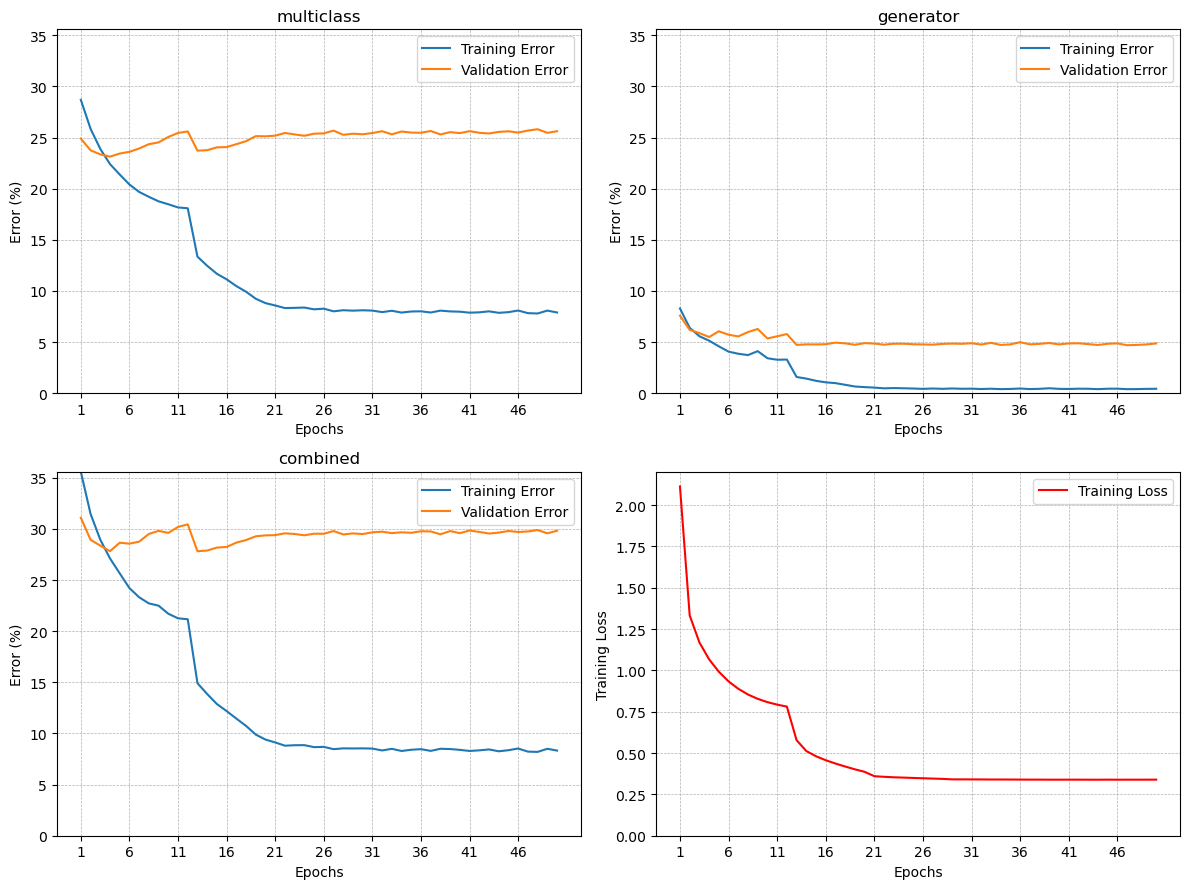

In [3]:
model_init_function = models.multiclass_finetuning
epochs = 50
batch_size = 64
lr = 0.001
val_batch_size = 64
scheduler_patience=7

val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=6, prefetch_factor=6, pin_memory=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True, prefetch_factor=6)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_complete_v3_batch{batch_size}"
print("\n\n - " + model_name)
writer = SummaryWriter('logs/'+model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl, writer=writer, scheduler_patience=scheduler_patience)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['generator'])}"
writer.close()

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)

In [3]:
model_init_function = models.multiclass_finetuning
model = model_init_function()
model = model.to(device)
test_dl = DataLoader(test_ds, batch_size=64)
weights_filename = "multiclass_finetuning_short_v2_batch64_epochs17.pth"
model.load_state_dict(torch.load(os.path.join('./weights', weights_filename)))

errors, mAPs = functions.multioutput_accuracy_map(device, model, test_dl, {"generator":9,"multiclass":1000})
print(" Errors")
for x in errors:
    print(f"{x}: {errors[x]*100:.2f}%")
print("\n mAPs")
for x in mAPs:
    print(f"{x}: {mAPs[x]*100:.2f}%")

/home/scardovi/anaconda3/envs/tinyllava/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


 Errors
multiclass: 22.94%
generator: 5.00%
combined: 27.30%

 mAPs
multiclass: 58.08%
generator: 85.84%


In [3]:
model_init_function = models.multiclass_finetuning
model = model_init_function()
model = model.to(device)
test_dl = DataLoader(test_ds, batch_size=64)
weights_filename = "multiclass_finetuning_short_v2_batch64_epochs17.pth"
model.load_state_dict(torch.load(os.path.join('./weights', weights_filename)))

error, mAP = functions.multioutput_accuracy_map_modified(device, model, test_dl, {"generator":9,"multiclass":1000})
print(f"binary error: {error*100:.2f}%")
print(f"binary mAP: {mAP*100:.2f}%")

/home/scardovi/anaconda3/envs/tinyllava/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


binary error: 0.56%
binary mAP: 99.89%


In [3]:
model_init_function = models.multiclass_finetuning
model = model_init_function()
model = model.to(device)
test_dl = DataLoader(test_ds, batch_size=64)
weights_filename = "multiclass_finetuning_short_v2_batch64_epochs17.pth"
model.load_state_dict(torch.load(os.path.join('./weights', weights_filename)))

error = functions.natural_accuracy(device, model, test_dl, {"generator":9,"multiclass":1000})
print(f"ilsvrc error: {error*100:.2f}%")

/home/scardovi/anaconda3/envs/tinyllava/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


ilsvrc error: 26.93%
